In [1]:
import torch
import torchvision
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
from torch.autograd import Variable
from tf2onnx import convert
import numpy as np
from model_src.comp_graph.tf_comp_graph_dataloaders import CGRegressDataLoader
from tqdm import tqdm
from model_src.comp_graph.tf_comp_graph_models import make_cg_regressor, make_embedding_model, make_embedding_regressor_model
import torch_geometric
from utils.model_utils import set_random_seed, device, add_weight_decay, get_activ_by_name
import argparse
from model_src.comp_graph.tf_comp_graph import ComputeGraph, OP2I
from utils.model_utils import model_load
from constants import *
from params import *


/opt/conda/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-21 14:08:19.144332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 14:08:20.002518: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 14:08:22.479535: W tensorflow/compiler/xla/stream_executor/platform/default/dso

In [2]:
def _batch_fwd_func(_model, _batch):
        # Define how a batch is handled by the model
        regular_node_inds = _batch[DK_BATCH_CG_REGULAR_IDX]
        regular_node_shapes = _batch[DK_BATCH_CG_REGULAR_SHAPES]
        weighted_node_inds = _batch[DK_BATCH_CG_WEIGHTED_IDX]
        weighted_node_shapes = _batch[DK_BATCH_CG_WEIGHTED_SHAPES]
        weighted_node_kernels = _batch[DK_BATCH_CG_WEIGHTED_KERNELS]
        weighted_node_bias = _batch[DK_BATCH_CG_WEIGHTED_BIAS]
        edge_tsr_list = _batch[DK_BATCH_EDGE_TSR_LIST]
        batch_last_node_idx_list = _batch[DK_BATCH_LAST_NODE_IDX_LIST]
        # return _model(regular_node_inds, regular_node_shapes,
        #               weighted_node_inds, weighted_node_shapes, weighted_node_kernels, weighted_node_bias,
        #               edge_tsr_list, batch_last_node_idx_list)
        node_embedding = _model.embed_layer(regular_node_inds, regular_node_shapes,
                                          weighted_node_inds, weighted_node_shapes,
                                          weighted_node_kernels, weighted_node_bias)
        
        encoder_output = _model.encoder(node_embedding, edge_tsr_list, batch_last_node_idx_list)
        
        return encoder_output

In [3]:
def gnn_constructor(in_channels, out_channels):
        nn = torch.nn.Sequential(torch.nn.Linear(in_channels, in_channels),
                                torch.nn.Linear(in_channels, out_channels),
                                )
        return torch_geometric.nn.GINConv(nn=nn)

In [4]:
model = make_embedding_model(n_unique_labels=len(OP2I().build_from_file()), out_embed_size=256,
                              shape_embed_size=8, kernel_embed_size=8, n_unique_kernels=8, n_shape_vals=6,
                              hidden_size=256, out_channels=256,
                              gnn_constructor=gnn_constructor,
                              gnn_activ=get_activ_by_name("relu"), n_gnn_layers=6,
                              dropout_prob=0.3, aggr_method="gnn",
                              regressor_activ=get_activ_by_name(None)).to(device())

In [5]:
checkpoint_file_name = "/home/ec2-user/nas-rec-engine/saved_models/gpi_acc_predictor_CL_dropout_encoder64_decoder_model_new_loss_seed109_best.pt"

In [6]:
checkpoint_file = checkpoint_file_name
if os.path.isfile(checkpoint_file):
    sd = model_load(checkpoint_file)
    try:
        model.load_state_dict(sd[CHKPT_MODEL], strict=True)
    except Exception:
        # Handles the thop bug
        state_dict = []
        for n, p in sd[CHKPT_MODEL].items():
            if "total_ops" not in n and "total_params" not in n:
                state_dict.append((n, p))
        model.load_state_dict(dict(state_dict), strict=strict)
    print(sd[CHKPT_BEST_EVAL_RESULT],sd[CHKPT_BEST_EVAL_ITERATION])

-1.7490580685377122 193


In [7]:
lstm_layer = torch.nn.LSTM(input_size=512, hidden_size=128, num_layers=2).to(device())

In [7]:
import random
from utils.misc_utils import RunningStatMeter
from model_src.model_helpers import BookKeeper
from model_src.predictor.gpi_family_data_manager import FamilyDataManager
from model_src.comp_graph.tf_comp_graph_dataloaders import CGRegressDataLoader

model_name = "gpi_acc_predictor_CL_dropout_encoder256_decoder_model_seed109_best.pt"
book_keeper = BookKeeper(log_file_name=model_name + ".txt",
                        model_name=model_name,
                        saved_models_dir="saved_models",
                        init_eval_perf=float("inf"), eval_perf_comp_func=lambda old, new: new < old,
                        saved_model_file="saved_models/default_model.pt",
                        logs_dir="logs/")


families_train = ["nb101"]
families_test = ["nb201c10"]

book_keeper.log("Params: {}".format("nothing"), verbose=False)
set_random_seed(109, log_f=book_keeper.log)
book_keeper.log("Train Families: {}".format(families_train))
book_keeper.log("Test Families: {}".format(families_test))

data_manager = FamilyDataManager(families_train, log_f=book_keeper.log)
family2sets = \
    data_manager.get_regress_train_dev_test_sets(0.1, 0.1,
                                                normalize_HW_per_family=False,
                                                normalize_target=False, group_by_family=True)

train_data, dev_data, test_data = [], [], []
for f, (fam_train, fam_dev, fam_test) in family2sets.items():
    train_data.extend(fam_train)
    dev_data.extend(fam_dev)
    test_data.extend(fam_test)

random.shuffle(train_data)
random.shuffle(dev_data)
random.shuffle(test_data)
book_keeper.log("Train size: {}".format(len(train_data)))
book_keeper.log("Dev size: {}".format(len(dev_data)))
book_keeper.log("Test size: {}".format(len(test_data)))

b_node_size_meter = RunningStatMeter()
for g, _ in train_data + dev_data + test_data:
    b_node_size_meter.update(len(g))
book_keeper.log("Max num nodes: {}".format(b_node_size_meter.max))
book_keeper.log("Min num nodes: {}".format(b_node_size_meter.min))
book_keeper.log("Avg num nodes: {}".format(b_node_size_meter.avg))

train_loader = CGRegressDataLoader(32, train_data)
dev_loader = CGRegressDataLoader(32, dev_data)
test_loader = CGRegressDataLoader(32, test_data)

Model name: gpi_acc_predictor_CL_dropout_encoder256_decoder_model_seed109_best.pt
Saved models dir: saved_models
Log dir: logs/
My seed is 109
My cuda seed is 109
Train Families: ['nb101']
Test Families: ['nb201c10']
Cache validated for ['nb101']
Loading nb101 cache data...
Specified normalize_HW_per_family=False
Family nb101 train size: 40000
Family nb101 dev size: 5000
Family nb101 test size: 5000
Max nb101 target value: 0.9409388303756714
Min nb101 target value: 0.09995993723471959
Avg nb101 target value: 0.8968612016542681
Max global target value: 0.9409388303756714
Min global target value: 0.09995993723471959
Avg global target value: 0.8968612016542681
Train size: 40000
Dev size: 5000
Test size: 5000
Max num nodes: 288
Min num nodes: 54
Avg num nodes: 190.43892


Building batches: 100%|##########| 185/185 [00:07<00:00, 25.97it/s]


In [8]:
batch_vals = []
model = model.to(device())

with torch.no_grad():
    model.eval()
    for batch in tqdm(train_loader, desc="Dev", ascii=True):
        output = _batch_fwd_func(model, batch)
        # Extract the final hidden state of the LSTM layer as the aggregated representation
        
        aggregated_representation = output.mean(dim=1)
        batch_vals.append(aggregated_representation)


Dev: 100%|##########| 1285/1285 [00:43<00:00, 29.27it/s]


In [10]:
import torch.nn as nn

class MDN(nn.Module):
    def __init__(self, input_size, hidden_size, num_components):
        super(MDN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_components = num_components
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_components * 3)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        mu, log_sigma, log_alpha = torch.chunk(x, 3, dim=1)
        alpha = torch.softmax(log_alpha, dim=1)
        sigma = torch.exp(log_sigma)
        return mu, sigma, alpha

In [13]:


def train(model, data, num_epochs, batch_size, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, x in enumerate(data):
            optimizer.zero_grad()
            mu, sigma, alpha = model(x)
            #print("alpha", alpha.shape, "mu", mu.shape, "sigma", sigma.shape)
            loss = 0.0
            
            for i in range(alpha.shape[0]):
                dist = torch.distributions.normal.Normal(mu, sigma)
                log_prob = dist.log_prob(alpha[i])
                #log_prob += torch.log(alpha[i, component[i]])
                loss -= log_prob.mean()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/(batch_idx+1):.4f}")


In [27]:
input_dims = 128
num_gaussians = 15
batch_size = 32
learning_rate = 0.001
N = 100

clustering_model = MDN(input_dims, input_dims, 15).to(device())

train(clustering_model, batch_vals, N, batch_size, learning_rate)


Epoch 1/100, Loss: -117.9094
Epoch 2/100, Loss: -136.9381
Epoch 3/100, Loss: -138.3848
Epoch 4/100, Loss: -143.7875
Epoch 5/100, Loss: -150.5603
Epoch 6/100, Loss: -145.0023
Epoch 7/100, Loss: -141.2547
Epoch 8/100, Loss: -150.9168
Epoch 9/100, Loss: -156.3852
Epoch 10/100, Loss: -154.6525
Epoch 11/100, Loss: -157.3874
Epoch 12/100, Loss: -121.4978
Epoch 13/100, Loss: -153.6398
Epoch 14/100, Loss: -155.7081
Epoch 15/100, Loss: -131.5782
Epoch 16/100, Loss: -157.9617
Epoch 17/100, Loss: -163.1243
Epoch 18/100, Loss: -165.2489
Epoch 19/100, Loss: -161.5968
Epoch 20/100, Loss: -166.6997


KeyboardInterrupt: 

In [11]:
torch.save(model.state_dict(), "saved_models/clustering.pt")

In [12]:
model.load_state_dict(torch.load('saved_models/clustering.pt'))
model.eval()


GraphAutoEncoder(
  (embed_layer): CGNodeEmbedding(
    (regular_embed_layer): Embedding(32, 248)
    (weighted_embed_layer): Embedding(32, 238)
    (kernel_embed_layer): Embedding(8, 4)
    (shape_embed_layer): Linear(in_features=6, out_features=8, bias=True)
    (bias_embed_layer): Linear(in_features=2, out_features=2, bias=True)
  )
  (encoder): PreEmbeddedGraphEncoderWithAttention(
    (gnn_layers): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Linear(in_features=256, out_features=256, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Linear(in_features=256, out_features=256, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Linear(in_features=256, out_features=256, bias=True)
      ))
      (3): GINConv(nn=Sequential(
        (0): Linear(in

In [40]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=16, random_state=109, n_init="auto")
results = kmeans.fit_transform(torch.cat(batch_vals).cpu())


In [41]:
assignment = kmeans.predict(torch.cat(batch_vals).cpu())

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=40, n_iter=600)
results = tsne.fit_transform(torch.cat(batch_vals).cpu())

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [23]:
import pandas as pd

# Create dataframe
tsne_df = pd.DataFrame(
    data=results, 
    columns=['Component 1', 'Component 2', 'Component 3'])
tsne_df['target'] = assignment

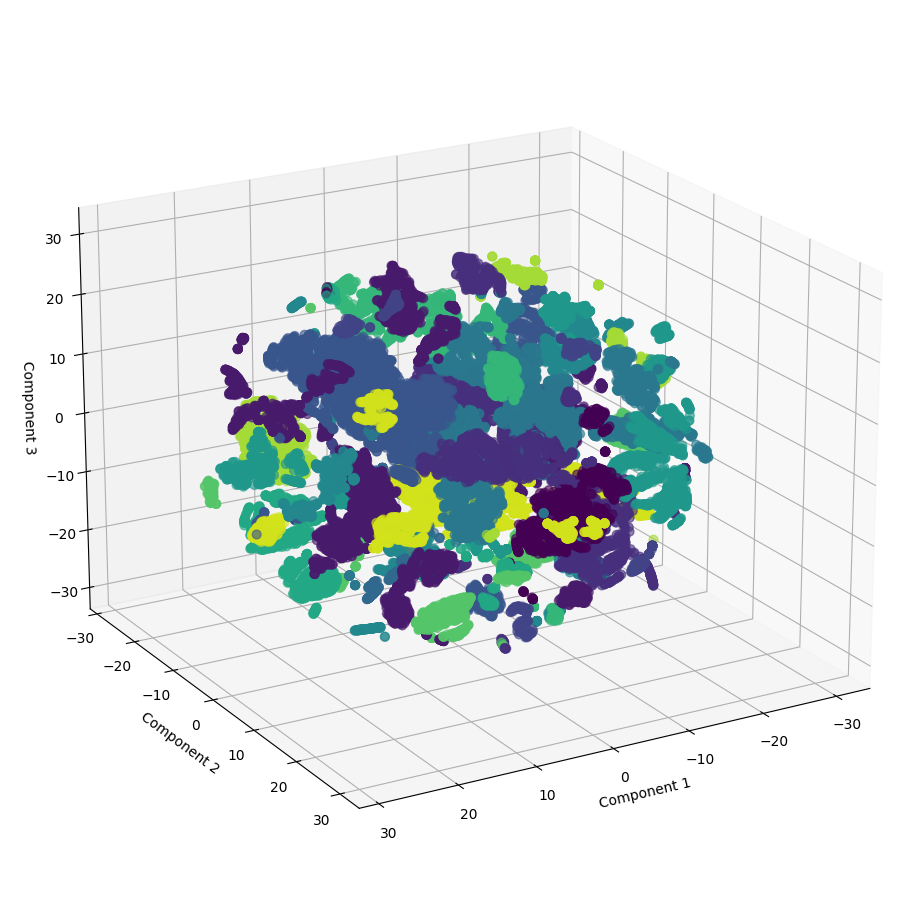

In [18]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
x = tsne_df['Component 1'].values
y = tsne_df['Component 2'].values
z = tsne_df['Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=tsne_df['target'].values, marker='o', cmap=cmap, alpha=0.6)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# save
plt.savefig("tsne_scatter_hue", bbox_inches='tight')

In [26]:
tsne_df.to_csv("tsne_results.csv")

In [12]:
import pandas as pd

tsne_df = pd.read_csv("tsne_results.csv")
tsne_df.head()

Unnamed: 0  Component 1  Component 2  Component 3  target
0           0   -18.860634     1.611424   -13.055912      14
1           1   -18.738540     1.298855   -13.473179      14
2           2     1.981018     1.688956     3.431181       6
3           3    -5.799727     1.980288     9.167614       6
4           4   -14.406397    -1.998355   -20.411694      11

In [13]:
truth_batch_vals = torch.tensor([]).to(device())
for batch in tqdm(train_loader, desc="Dev", ascii=True):
    truth = batch[DK_BATCH_TARGET_TSR].to(device())
    #print(truth.shape)
    truth_batch_vals = torch.cat([truth_batch_vals, truth])

Dev: 100%|##########| 1285/1285 [00:00<00:00, 34681.51it/s]


In [15]:
# Create dataframe
tsne_df2 = tsne_df.copy()
tsne_df2['target'] = truth_batch_vals.cpu()

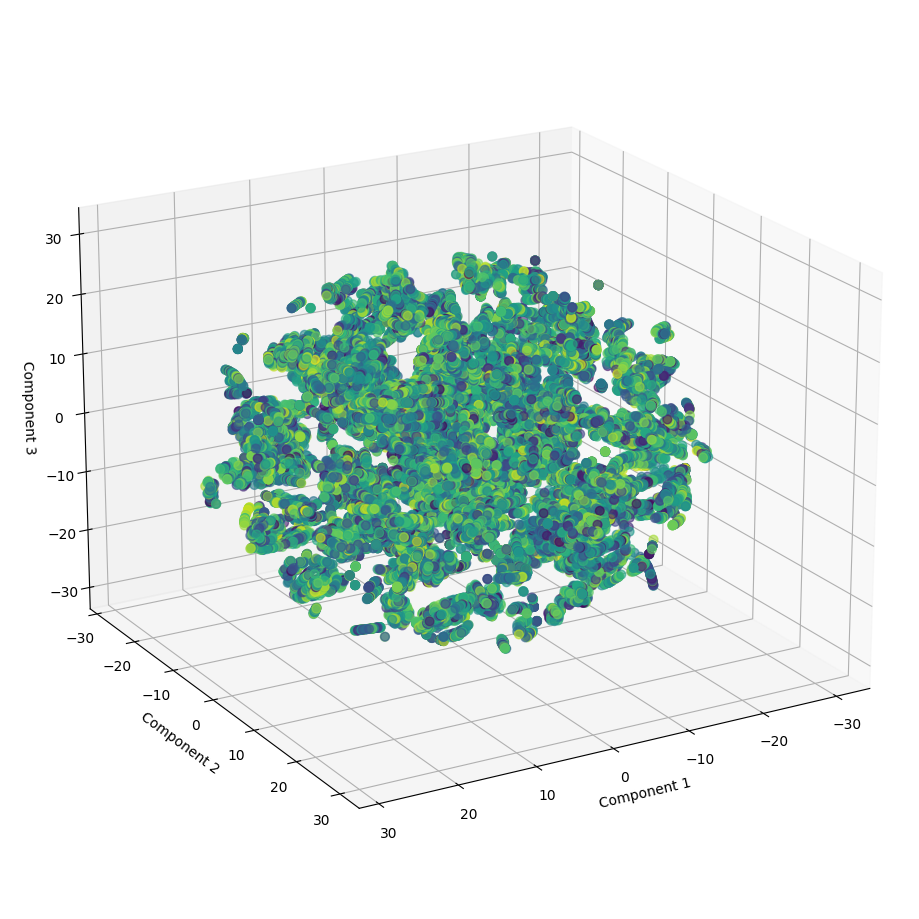

In [19]:
new_tsne_df2 = tsne_df2[tsne_df2["target"] > 0.87]


# generate data
x = new_tsne_df2['Component 1'].values
y = new_tsne_df2['Component 2'].values
z = new_tsne_df2['Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=new_tsne_df2['target'].values, marker='o', cmap=cmap, alpha=0.6)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# save
plt.savefig("tsne_scatter_hue", bbox_inches='tight')

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        # Apply softmax activation to get the soft label probabilities
        x = torch.softmax(x, dim=1)
        return x

In [44]:
truth_label_batch_vals = []
for batch in batch_vals:
    labels = kmeans.predict(batch.cpu())
    t_labels = torch.tensor(labels).to(device())
    truth_label_batch_vals.append(t_labels)

In [100]:
# Set hyperparameters
input_size = 512
hidden_size = 1024
output_size = 16
learning_rate = 0.05
num_epochs = 200

In [101]:
# Initialize the model, loss function, and optimizer
#classification_model = MLP(input_size, hidden_size, output_size).to(device())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classification_model.parameters(), lr=learning_rate)

In [102]:
# Train the model
classification_model.train()
for epoch in tqdm(range(num_epochs)):
    for inputs, labels in zip(batch_vals, truth_label_batch_vals):
        # Forward pass
        outputs = classification_model(inputs)
        outputs = outputs + 1e-8
        # Calculate the soft label loss
        soft_label_loss = nn.KLDivLoss(reduction='batchmean')(torch.log(outputs), torch.nn.functional.one_hot(labels.long(), num_classes=output_size).float())
        # Calculate the hard label loss
        #print(labels.shape, labels.type())
        #labels = torch.nn.functional.one_hot(labels.long(), num_classes=output_size).float()
        hard_label_loss = criterion(outputs, labels.long())
        # Calculate the total loss as the weighted sum of the two losses
        loss = 0.5 * hard_label_loss + 0.5 * soft_label_loss
        #loss = hard_label_loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print the loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

  0%|          | 1/200 [00:01<05:25,  1.64s/it]

Epoch 1/200, Loss: 0.9385


  1%|          | 2/200 [00:03<05:22,  1.63s/it]

Epoch 2/200, Loss: 0.9384


  2%|▏         | 3/200 [00:04<05:19,  1.62s/it]

Epoch 3/200, Loss: 0.9386


  2%|▏         | 4/200 [00:06<05:19,  1.63s/it]

Epoch 4/200, Loss: 0.9386


  2%|▎         | 5/200 [00:08<05:17,  1.63s/it]

Epoch 5/200, Loss: 0.9386


  3%|▎         | 6/200 [00:09<05:16,  1.63s/it]

Epoch 6/200, Loss: 0.9385


  4%|▎         | 7/200 [00:11<05:14,  1.63s/it]

Epoch 7/200, Loss: 0.9384


  4%|▍         | 8/200 [00:13<05:14,  1.64s/it]

Epoch 8/200, Loss: 0.9386


  4%|▍         | 9/200 [00:14<05:10,  1.63s/it]

Epoch 9/200, Loss: 0.9384


  5%|▌         | 10/200 [00:16<05:09,  1.63s/it]

Epoch 10/200, Loss: 0.9384


  6%|▌         | 11/200 [00:17<05:05,  1.62s/it]

Epoch 11/200, Loss: 0.9385


  6%|▌         | 12/200 [00:19<05:05,  1.63s/it]

Epoch 12/200, Loss: 0.9384


  6%|▋         | 13/200 [00:21<05:02,  1.62s/it]

Epoch 13/200, Loss: 0.9383


  7%|▋         | 14/200 [00:22<05:01,  1.62s/it]

Epoch 14/200, Loss: 0.9383


  8%|▊         | 15/200 [00:24<05:01,  1.63s/it]

Epoch 15/200, Loss: 0.9382


  8%|▊         | 16/200 [00:26<05:00,  1.63s/it]

Epoch 16/200, Loss: 0.9382


  8%|▊         | 17/200 [00:27<04:58,  1.63s/it]

Epoch 17/200, Loss: 0.9381


  9%|▉         | 18/200 [00:29<04:57,  1.63s/it]

Epoch 18/200, Loss: 0.9381


 10%|▉         | 19/200 [00:30<04:56,  1.64s/it]

Epoch 19/200, Loss: 0.9381


 10%|█         | 20/200 [00:32<04:56,  1.65s/it]

Epoch 20/200, Loss: 0.9380


 10%|█         | 21/200 [00:34<04:53,  1.64s/it]

Epoch 21/200, Loss: 0.9380


 11%|█         | 22/200 [00:35<04:51,  1.63s/it]

Epoch 22/200, Loss: 0.9380


 12%|█▏        | 23/200 [00:37<04:49,  1.64s/it]

Epoch 23/200, Loss: 0.9380


 12%|█▏        | 24/200 [00:39<04:54,  1.67s/it]

Epoch 24/200, Loss: 0.9380


 12%|█▎        | 25/200 [00:41<04:57,  1.70s/it]

Epoch 25/200, Loss: 0.9380


 13%|█▎        | 26/200 [00:42<04:59,  1.72s/it]

Epoch 26/200, Loss: 0.9379


 14%|█▎        | 27/200 [00:44<05:00,  1.74s/it]

Epoch 27/200, Loss: 0.9379


 14%|█▍        | 28/200 [00:46<05:00,  1.75s/it]

Epoch 28/200, Loss: 0.9379


 14%|█▍        | 29/200 [00:48<04:59,  1.75s/it]

Epoch 29/200, Loss: 0.9379


 15%|█▌        | 30/200 [00:49<04:56,  1.74s/it]

Epoch 30/200, Loss: 0.9378


 16%|█▌        | 31/200 [00:51<04:50,  1.72s/it]

Epoch 31/200, Loss: 0.9378


 16%|█▌        | 32/200 [00:53<04:46,  1.70s/it]

Epoch 32/200, Loss: 0.9378


 16%|█▋        | 33/200 [00:54<04:43,  1.70s/it]

Epoch 33/200, Loss: 0.9378


 17%|█▋        | 34/200 [00:56<04:45,  1.72s/it]

Epoch 34/200, Loss: 0.9378


 18%|█▊        | 35/200 [00:58<04:42,  1.71s/it]

Epoch 35/200, Loss: 0.9378


 18%|█▊        | 36/200 [00:59<04:36,  1.68s/it]

Epoch 36/200, Loss: 0.9378


 18%|█▊        | 37/200 [01:01<04:37,  1.70s/it]

Epoch 37/200, Loss: 0.9378


 19%|█▉        | 38/200 [01:03<04:38,  1.72s/it]

Epoch 38/200, Loss: 0.9378


 20%|█▉        | 39/200 [01:05<04:32,  1.69s/it]

Epoch 39/200, Loss: 0.9378


 20%|██        | 40/200 [01:06<04:27,  1.67s/it]

Epoch 40/200, Loss: 0.9377


 20%|██        | 41/200 [01:08<04:24,  1.66s/it]

Epoch 41/200, Loss: 0.9378


 21%|██        | 42/200 [01:09<04:20,  1.65s/it]

Epoch 42/200, Loss: 0.9378


 22%|██▏       | 43/200 [01:11<04:17,  1.64s/it]

Epoch 43/200, Loss: 0.9377


 22%|██▏       | 44/200 [01:13<04:16,  1.64s/it]

Epoch 44/200, Loss: 0.9378


 22%|██▎       | 45/200 [01:14<04:16,  1.66s/it]

Epoch 45/200, Loss: 0.9377


 23%|██▎       | 46/200 [01:16<04:12,  1.64s/it]

Epoch 46/200, Loss: 0.9378


 24%|██▎       | 47/200 [01:18<04:09,  1.63s/it]

Epoch 47/200, Loss: 0.9378


 24%|██▍       | 48/200 [01:19<04:06,  1.62s/it]

Epoch 48/200, Loss: 0.9377


 24%|██▍       | 49/200 [01:21<04:05,  1.63s/it]

Epoch 49/200, Loss: 0.9378


 25%|██▌       | 50/200 [01:22<04:03,  1.62s/it]

Epoch 50/200, Loss: 0.9378


 26%|██▌       | 51/200 [01:24<04:01,  1.62s/it]

Epoch 51/200, Loss: 0.9377


 26%|██▌       | 52/200 [01:26<03:59,  1.62s/it]

Epoch 52/200, Loss: 0.9377


 26%|██▋       | 53/200 [01:27<03:59,  1.63s/it]

Epoch 53/200, Loss: 0.9377


 27%|██▋       | 54/200 [01:29<04:00,  1.65s/it]

Epoch 54/200, Loss: 0.9378


 28%|██▊       | 55/200 [01:31<03:57,  1.64s/it]

Epoch 55/200, Loss: 0.9377


 28%|██▊       | 56/200 [01:32<03:54,  1.63s/it]

Epoch 56/200, Loss: 0.9377


 28%|██▊       | 57/200 [01:34<03:53,  1.64s/it]

Epoch 57/200, Loss: 0.9377


 29%|██▉       | 58/200 [01:36<03:52,  1.64s/it]

Epoch 58/200, Loss: 0.9378


 30%|██▉       | 59/200 [01:37<03:50,  1.63s/it]

Epoch 59/200, Loss: 0.9377


 30%|███       | 60/200 [01:39<03:48,  1.63s/it]

Epoch 60/200, Loss: 0.9377


 30%|███       | 61/200 [01:40<03:47,  1.64s/it]

Epoch 61/200, Loss: 0.9377


 31%|███       | 62/200 [01:42<03:44,  1.63s/it]

Epoch 62/200, Loss: 0.9377


 32%|███▏      | 63/200 [01:44<03:43,  1.63s/it]

Epoch 63/200, Loss: 0.9377


 32%|███▏      | 64/200 [01:45<03:40,  1.62s/it]

Epoch 64/200, Loss: 0.9377


 32%|███▎      | 65/200 [01:47<03:41,  1.64s/it]

Epoch 65/200, Loss: 0.9377


 33%|███▎      | 66/200 [01:49<03:38,  1.63s/it]

Epoch 66/200, Loss: 0.9377


 34%|███▎      | 67/200 [01:50<03:36,  1.62s/it]

Epoch 67/200, Loss: 0.9376


 34%|███▍      | 68/200 [01:52<03:34,  1.63s/it]

Epoch 68/200, Loss: 0.9376


 34%|███▍      | 69/200 [01:54<03:38,  1.67s/it]

Epoch 69/200, Loss: 0.9376


 35%|███▌      | 70/200 [01:55<03:34,  1.65s/it]

Epoch 70/200, Loss: 0.9376


 36%|███▌      | 71/200 [01:57<03:32,  1.64s/it]

Epoch 71/200, Loss: 0.9377


 36%|███▌      | 72/200 [01:58<03:28,  1.63s/it]

Epoch 72/200, Loss: 0.9376


 36%|███▋      | 73/200 [02:00<03:27,  1.64s/it]

Epoch 73/200, Loss: 0.9377


 37%|███▋      | 74/200 [02:02<03:27,  1.64s/it]

Epoch 74/200, Loss: 0.9377


 38%|███▊      | 75/200 [02:03<03:27,  1.66s/it]

Epoch 75/200, Loss: 0.9376


 38%|███▊      | 76/200 [02:05<03:23,  1.64s/it]

Epoch 76/200, Loss: 0.9377


 38%|███▊      | 77/200 [02:07<03:22,  1.65s/it]

Epoch 77/200, Loss: 0.9376


 39%|███▉      | 78/200 [02:08<03:19,  1.63s/it]

Epoch 78/200, Loss: 0.9377


 40%|███▉      | 79/200 [02:10<03:22,  1.67s/it]

Epoch 79/200, Loss: 0.9377


 40%|████      | 80/200 [02:12<03:18,  1.65s/it]

Epoch 80/200, Loss: 0.9376


 40%|████      | 81/200 [02:13<03:16,  1.65s/it]

Epoch 81/200, Loss: 0.9376


 41%|████      | 82/200 [02:15<03:12,  1.64s/it]

Epoch 82/200, Loss: 0.9376


 42%|████▏     | 83/200 [02:17<03:10,  1.63s/it]

Epoch 83/200, Loss: 0.9376


 42%|████▏     | 84/200 [02:18<03:07,  1.62s/it]

Epoch 84/200, Loss: 0.9376


 42%|████▎     | 85/200 [02:20<03:06,  1.62s/it]

Epoch 85/200, Loss: 0.9376


 43%|████▎     | 86/200 [02:21<03:05,  1.63s/it]

Epoch 86/200, Loss: 0.9376


 44%|████▎     | 87/200 [02:23<03:06,  1.65s/it]

Epoch 87/200, Loss: 0.9376


 44%|████▍     | 88/200 [02:25<03:03,  1.64s/it]

Epoch 88/200, Loss: 0.9376


 44%|████▍     | 89/200 [02:26<03:01,  1.64s/it]

Epoch 89/200, Loss: 0.9376


 45%|████▌     | 90/200 [02:28<02:59,  1.63s/it]

Epoch 90/200, Loss: 0.9376


 46%|████▌     | 91/200 [02:30<02:57,  1.63s/it]

Epoch 91/200, Loss: 0.9376


 46%|████▌     | 92/200 [02:31<02:55,  1.63s/it]

Epoch 92/200, Loss: 0.9376


 46%|████▋     | 93/200 [02:33<02:55,  1.64s/it]

Epoch 93/200, Loss: 0.9376


 47%|████▋     | 94/200 [02:35<02:54,  1.64s/it]

Epoch 94/200, Loss: 0.9376


 48%|████▊     | 95/200 [02:36<02:56,  1.68s/it]

Epoch 95/200, Loss: 0.9376


 48%|████▊     | 96/200 [02:38<02:57,  1.70s/it]

Epoch 96/200, Loss: 0.9376


 48%|████▊     | 97/200 [02:40<02:57,  1.72s/it]

Epoch 97/200, Loss: 0.9376


 49%|████▉     | 98/200 [02:42<02:56,  1.74s/it]

Epoch 98/200, Loss: 0.9376


 50%|████▉     | 99/200 [02:43<02:54,  1.73s/it]

Epoch 99/200, Loss: 0.9376


 50%|█████     | 100/200 [02:45<02:49,  1.69s/it]

Epoch 100/200, Loss: 0.9376


 50%|█████     | 101/200 [02:47<02:46,  1.68s/it]

Epoch 101/200, Loss: 0.9376


 51%|█████     | 102/200 [02:48<02:42,  1.66s/it]

Epoch 102/200, Loss: 0.9376


 52%|█████▏    | 103/200 [02:50<02:40,  1.66s/it]

Epoch 103/200, Loss: 0.9375


 52%|█████▏    | 104/200 [02:52<02:39,  1.66s/it]

Epoch 104/200, Loss: 0.9375


 52%|█████▎    | 105/200 [02:53<02:37,  1.66s/it]

Epoch 105/200, Loss: 0.9376


 53%|█████▎    | 106/200 [02:55<02:34,  1.65s/it]

Epoch 106/200, Loss: 0.9376


 54%|█████▎    | 107/200 [02:56<02:33,  1.65s/it]

Epoch 107/200, Loss: 0.9375


 54%|█████▍    | 108/200 [02:58<02:30,  1.64s/it]

Epoch 108/200, Loss: 0.9375


 55%|█████▍    | 109/200 [03:00<02:29,  1.64s/it]

Epoch 109/200, Loss: 0.9375


 55%|█████▌    | 110/200 [03:01<02:27,  1.63s/it]

Epoch 110/200, Loss: 0.9375


 56%|█████▌    | 111/200 [03:03<02:25,  1.64s/it]

Epoch 111/200, Loss: 0.9376


 56%|█████▌    | 112/200 [03:05<02:24,  1.64s/it]

Epoch 112/200, Loss: 0.9375


 56%|█████▋    | 113/200 [03:06<02:23,  1.64s/it]

Epoch 113/200, Loss: 0.9375


 57%|█████▋    | 114/200 [03:08<02:22,  1.65s/it]

Epoch 114/200, Loss: 0.9375


 57%|█████▊    | 115/200 [03:10<02:21,  1.66s/it]

Epoch 115/200, Loss: 0.9375


 58%|█████▊    | 116/200 [03:11<02:19,  1.66s/it]

Epoch 116/200, Loss: 0.9375


 58%|█████▊    | 117/200 [03:13<02:18,  1.67s/it]

Epoch 117/200, Loss: 0.9375


 59%|█████▉    | 118/200 [03:15<02:16,  1.67s/it]

Epoch 118/200, Loss: 0.9375


 60%|█████▉    | 119/200 [03:16<02:14,  1.66s/it]

Epoch 119/200, Loss: 0.9375


 60%|██████    | 120/200 [03:18<02:12,  1.66s/it]

Epoch 120/200, Loss: 0.9375


 60%|██████    | 121/200 [03:20<02:10,  1.66s/it]

Epoch 121/200, Loss: 0.9375


 61%|██████    | 122/200 [03:21<02:08,  1.65s/it]

Epoch 122/200, Loss: 0.9375


 62%|██████▏   | 123/200 [03:23<02:07,  1.66s/it]

Epoch 123/200, Loss: 0.9375


 62%|██████▏   | 124/200 [03:25<02:04,  1.64s/it]

Epoch 124/200, Loss: 0.9375


 62%|██████▎   | 125/200 [03:26<02:03,  1.64s/it]

Epoch 125/200, Loss: 0.9375


 63%|██████▎   | 126/200 [03:28<02:01,  1.64s/it]

Epoch 126/200, Loss: 0.9375


 64%|██████▎   | 127/200 [03:29<01:59,  1.64s/it]

Epoch 127/200, Loss: 0.9375


 64%|██████▍   | 128/200 [03:31<01:58,  1.64s/it]

Epoch 128/200, Loss: 0.9375


 64%|██████▍   | 129/200 [03:33<01:57,  1.65s/it]

Epoch 129/200, Loss: 0.9375


 65%|██████▌   | 130/200 [03:34<01:55,  1.64s/it]

Epoch 130/200, Loss: 0.9375


 66%|██████▌   | 131/200 [03:36<01:53,  1.64s/it]

Epoch 131/200, Loss: 0.9375


 66%|██████▌   | 132/200 [03:38<01:51,  1.64s/it]

Epoch 132/200, Loss: 0.9375


 66%|██████▋   | 133/200 [03:39<01:49,  1.64s/it]

Epoch 133/200, Loss: 0.9375


 67%|██████▋   | 134/200 [03:41<01:48,  1.64s/it]

Epoch 134/200, Loss: 0.9375


 68%|██████▊   | 135/200 [03:43<01:48,  1.67s/it]

Epoch 135/200, Loss: 0.9375


 68%|██████▊   | 136/200 [03:44<01:45,  1.65s/it]

Epoch 136/200, Loss: 0.9375


 68%|██████▊   | 137/200 [03:46<01:44,  1.65s/it]

Epoch 137/200, Loss: 0.9375


 69%|██████▉   | 138/200 [03:48<01:42,  1.65s/it]

Epoch 138/200, Loss: 0.9375


 70%|██████▉   | 139/200 [03:49<01:40,  1.65s/it]

Epoch 139/200, Loss: 0.9375


 70%|███████   | 140/200 [03:51<01:39,  1.65s/it]

Epoch 140/200, Loss: 0.9375


 70%|███████   | 141/200 [03:53<01:38,  1.68s/it]

Epoch 141/200, Loss: 0.9375


 71%|███████   | 142/200 [03:54<01:36,  1.66s/it]

Epoch 142/200, Loss: 0.9375


 72%|███████▏  | 143/200 [03:56<01:35,  1.68s/it]

Epoch 143/200, Loss: 0.9375


 72%|███████▏  | 144/200 [03:58<01:34,  1.69s/it]

Epoch 144/200, Loss: 0.9375


 72%|███████▎  | 145/200 [03:59<01:32,  1.68s/it]

Epoch 145/200, Loss: 0.9375


 73%|███████▎  | 146/200 [04:01<01:29,  1.66s/it]

Epoch 146/200, Loss: 0.9375


 74%|███████▎  | 147/200 [04:03<01:27,  1.66s/it]

Epoch 147/200, Loss: 0.9375


 74%|███████▍  | 148/200 [04:04<01:25,  1.64s/it]

Epoch 148/200, Loss: 0.9375


 74%|███████▍  | 149/200 [04:06<01:25,  1.68s/it]

Epoch 149/200, Loss: 0.9375


 75%|███████▌  | 150/200 [04:08<01:23,  1.67s/it]

Epoch 150/200, Loss: 0.9375


 76%|███████▌  | 151/200 [04:09<01:20,  1.65s/it]

Epoch 151/200, Loss: 0.9375


 76%|███████▌  | 152/200 [04:11<01:20,  1.68s/it]

Epoch 152/200, Loss: 0.9375


 76%|███████▋  | 153/200 [04:13<01:20,  1.71s/it]

Epoch 153/200, Loss: 0.9375


 77%|███████▋  | 154/200 [04:14<01:19,  1.72s/it]

Epoch 154/200, Loss: 0.9375


 78%|███████▊  | 155/200 [04:16<01:16,  1.70s/it]

Epoch 155/200, Loss: 0.9375


 78%|███████▊  | 156/200 [04:18<01:13,  1.67s/it]

Epoch 156/200, Loss: 0.9375


 78%|███████▊  | 157/200 [04:19<01:12,  1.68s/it]

Epoch 157/200, Loss: 0.9375


 79%|███████▉  | 158/200 [04:21<01:10,  1.67s/it]

Epoch 158/200, Loss: 0.9375


 80%|███████▉  | 159/200 [04:23<01:08,  1.68s/it]

Epoch 159/200, Loss: 0.9375


 80%|████████  | 160/200 [04:24<01:06,  1.66s/it]

Epoch 160/200, Loss: 0.9375


 80%|████████  | 161/200 [04:26<01:04,  1.66s/it]

Epoch 161/200, Loss: 0.9375


 81%|████████  | 162/200 [04:28<01:02,  1.64s/it]

Epoch 162/200, Loss: 0.9375


 82%|████████▏ | 163/200 [04:29<01:00,  1.64s/it]

Epoch 163/200, Loss: 0.9375


 82%|████████▏ | 164/200 [04:31<00:58,  1.63s/it]

Epoch 164/200, Loss: 0.9375


 82%|████████▎ | 165/200 [04:33<00:57,  1.63s/it]

Epoch 165/200, Loss: 0.9375


 83%|████████▎ | 166/200 [04:34<00:55,  1.63s/it]

Epoch 166/200, Loss: 0.9375


 84%|████████▎ | 167/200 [04:36<00:53,  1.63s/it]

Epoch 167/200, Loss: 0.9374


 84%|████████▍ | 168/200 [04:37<00:52,  1.63s/it]

Epoch 168/200, Loss: 0.9374


 84%|████████▍ | 169/200 [04:39<00:50,  1.64s/it]

Epoch 169/200, Loss: 0.9374


 85%|████████▌ | 170/200 [04:41<00:49,  1.64s/it]

Epoch 170/200, Loss: 0.9374


 86%|████████▌ | 171/200 [04:42<00:47,  1.65s/it]

Epoch 171/200, Loss: 0.9374


 86%|████████▌ | 172/200 [04:44<00:46,  1.65s/it]

Epoch 172/200, Loss: 0.9374


 86%|████████▋ | 173/200 [04:46<00:44,  1.66s/it]

Epoch 173/200, Loss: 0.9374


 87%|████████▋ | 174/200 [04:47<00:42,  1.65s/it]

Epoch 174/200, Loss: 0.9374


 88%|████████▊ | 175/200 [04:49<00:41,  1.66s/it]

Epoch 175/200, Loss: 0.9374


 88%|████████▊ | 176/200 [04:51<00:39,  1.66s/it]

Epoch 176/200, Loss: 0.9374


 88%|████████▊ | 177/200 [04:52<00:38,  1.66s/it]

Epoch 177/200, Loss: 0.9374


 89%|████████▉ | 178/200 [04:54<00:36,  1.66s/it]

Epoch 178/200, Loss: 0.9374


 90%|████████▉ | 179/200 [04:56<00:34,  1.66s/it]

Epoch 179/200, Loss: 0.9374


 90%|█████████ | 180/200 [04:57<00:33,  1.65s/it]

Epoch 180/200, Loss: 0.9374


 90%|█████████ | 181/200 [04:59<00:31,  1.65s/it]

Epoch 181/200, Loss: 0.9374


 91%|█████████ | 182/200 [05:01<00:29,  1.65s/it]

Epoch 182/200, Loss: 0.9374


 92%|█████████▏| 183/200 [05:02<00:27,  1.64s/it]

Epoch 183/200, Loss: 0.9374


 92%|█████████▏| 184/200 [05:04<00:26,  1.64s/it]

Epoch 184/200, Loss: 0.9374


 92%|█████████▎| 185/200 [05:06<00:24,  1.65s/it]

Epoch 185/200, Loss: 0.9374


 93%|█████████▎| 186/200 [05:07<00:23,  1.65s/it]

Epoch 186/200, Loss: 0.9374


 94%|█████████▎| 187/200 [05:09<00:21,  1.69s/it]

Epoch 187/200, Loss: 0.9374


 94%|█████████▍| 188/200 [05:11<00:20,  1.72s/it]

Epoch 188/200, Loss: 0.9374


 94%|█████████▍| 189/200 [05:12<00:18,  1.71s/it]

Epoch 189/200, Loss: 0.9374


 95%|█████████▌| 190/200 [05:14<00:16,  1.69s/it]

Epoch 190/200, Loss: 0.9374


 96%|█████████▌| 191/200 [05:16<00:15,  1.67s/it]

Epoch 191/200, Loss: 0.9845


 96%|█████████▌| 192/200 [05:17<00:13,  1.66s/it]

Epoch 192/200, Loss: 0.9590


 96%|█████████▋| 193/200 [05:19<00:11,  1.67s/it]

Epoch 193/200, Loss: 0.9552


 97%|█████████▋| 194/200 [05:21<00:09,  1.65s/it]

Epoch 194/200, Loss: 0.9540


 98%|█████████▊| 195/200 [05:22<00:08,  1.68s/it]

Epoch 195/200, Loss: 1.0178


 98%|█████████▊| 196/200 [05:24<00:06,  1.71s/it]

Epoch 196/200, Loss: 0.9568


 98%|█████████▊| 197/200 [05:26<00:05,  1.72s/it]

Epoch 197/200, Loss: 0.9587


 99%|█████████▉| 198/200 [05:28<00:03,  1.73s/it]

Epoch 198/200, Loss: 0.9420


100%|█████████▉| 199/200 [05:29<00:01,  1.71s/it]

Epoch 199/200, Loss: 0.9424


100%|██████████| 200/200 [05:31<00:00,  1.66s/it]

Epoch 200/200, Loss: 0.9432


In [103]:
torch.save(classification_model.state_dict(), "saved_models/clustering.pt")

In [104]:
classification_model = MLP(input_size, hidden_size, output_size).to(device())
classification_model.load_state_dict(torch.load("saved_models/clustering.pt"))
classification_model.eval()

MLP(
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=16, bias=True)
)

In [82]:
clustering_batch_vals = []
for batch in tqdm(batch_vals):
    with torch.no_grad():
        classification_model.eval()
        labels = classification_model(batch)
        values = torch.arange(1,17)*labels.cpu()
        mix_label = torch.sum(values, dim=1)
        clustering_batch_vals.append(mix_label)

100%|██████████| 1285/1285 [00:00<00:00, 4651.66it/s]


In [83]:
# Create dataframe
tsne_df3 = tsne_df.copy()
tsne_df3['target'] = torch.cat(clustering_batch_vals)

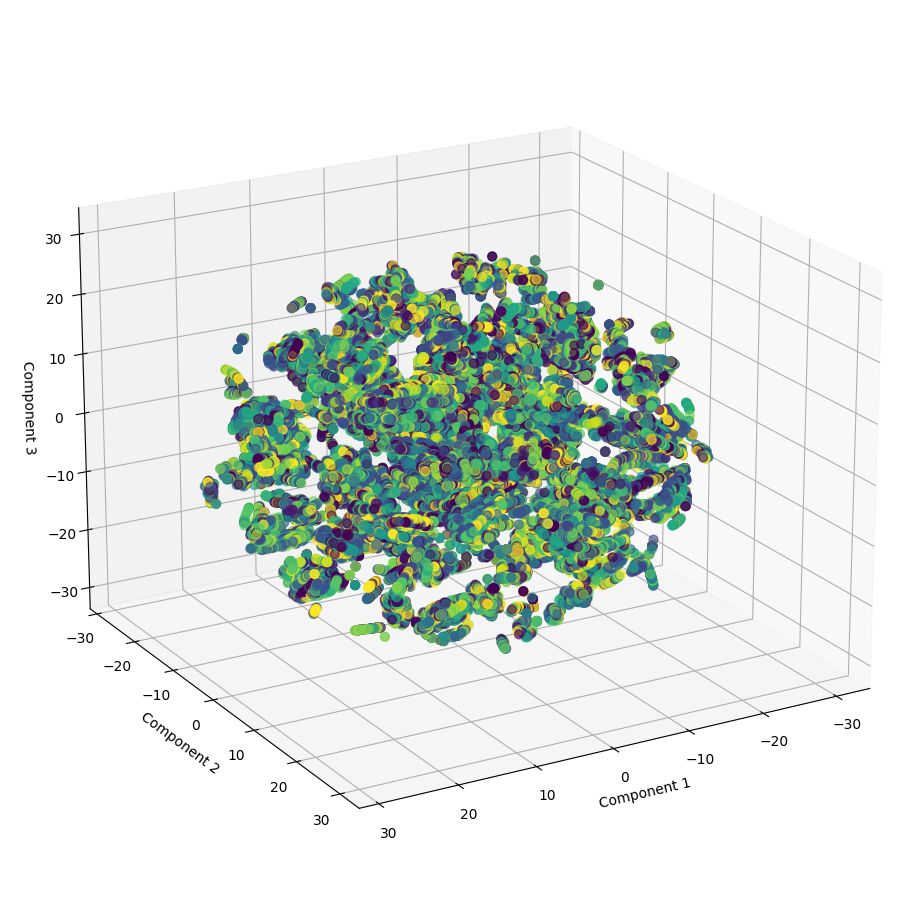

In [84]:
# generate data
from sklearn.preprocessing import MinMaxScaler

x = tsne_df3['Component 1'].values
y = tsne_df3['Component 2'].values
z = tsne_df3['Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
scaler = MinMaxScaler()
tsne_df3['target_scaled'] = scaler.fit_transform(tsne_df3[['target']])

sc = ax.scatter(x, y, z, s=40, c=tsne_df3['target_scaled'].values, marker='o', cmap=cmap, alpha=0.6)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# save
plt.savefig("tsne_scatter_hue", bbox_inches='tight')

In [87]:
single_clustering_batch_vals = []
for batch in tqdm(batch_vals):
    with torch.no_grad():
        classification_model.eval()
        labels = classification_model(batch)
        single_clustering_batch_vals.append(torch.argmax(labels, dim=1).cpu())

100%|██████████| 1285/1285 [00:00<00:00, 5680.62it/s]


In [88]:
# Create dataframe
tsne_df4= tsne_df.copy()
tsne_df4['target'] = torch.cat(single_clustering_batch_vals)

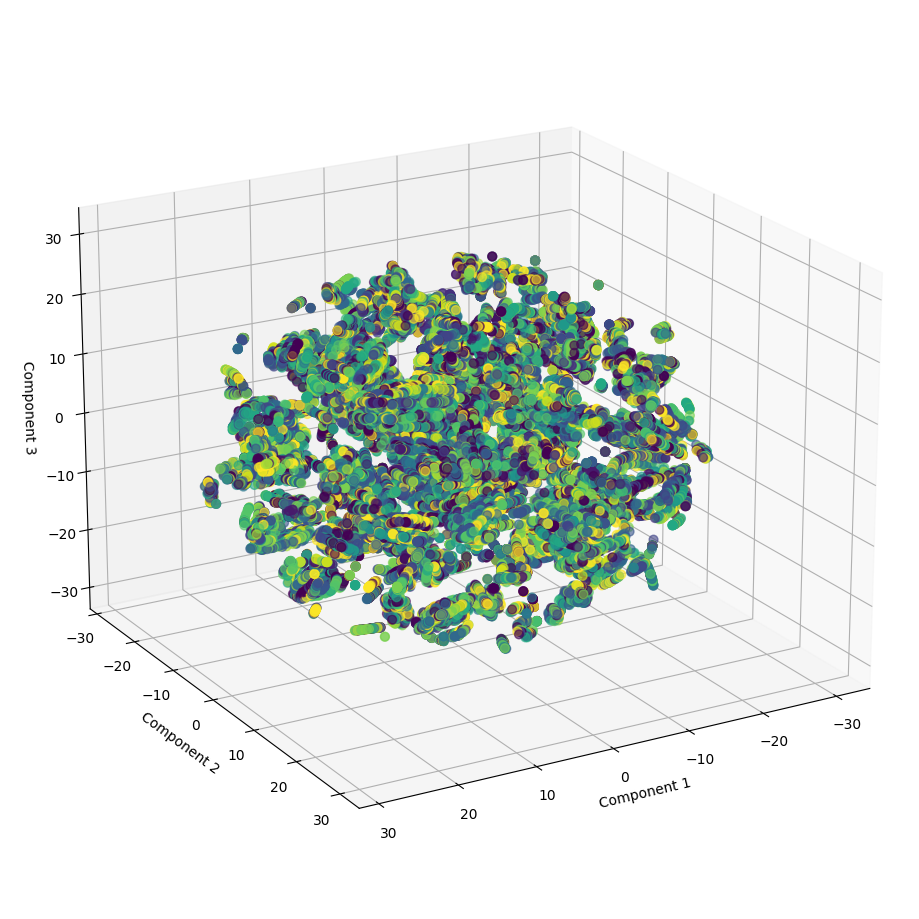

In [89]:
# generate data
x = tsne_df4['Component 1'].values
y = tsne_df4['Component 2'].values
z = tsne_df4['Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=tsne_df4['target'].values, marker='o', cmap=cmap, alpha=0.6)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# save
plt.savefig("tsne_scatter_hue", bbox_inches='tight')

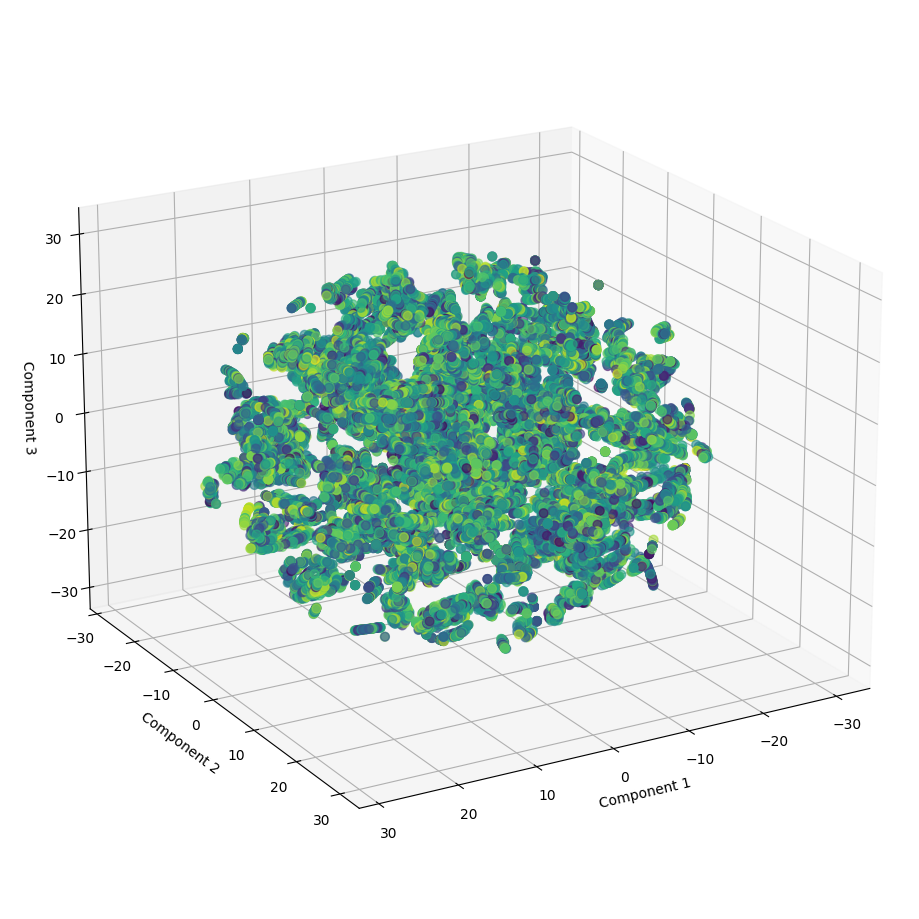

In [105]:
new_tsne_df2 = tsne_df2[tsne_df2["target"] > 0.87]


# generate data
x = new_tsne_df2['Component 1'].values
y = new_tsne_df2['Component 2'].values
z = new_tsne_df2['Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=new_tsne_df2['target'].values, marker='o', cmap=cmap, alpha=0.6)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# save
plt.savefig("tsne_scatter_hue", bbox_inches='tight')

/tmp/ipykernel_5892/2171387075.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_tsne_df3['target_scaled'] = scaler.fit_transform(new_tsne_df3[['target']])


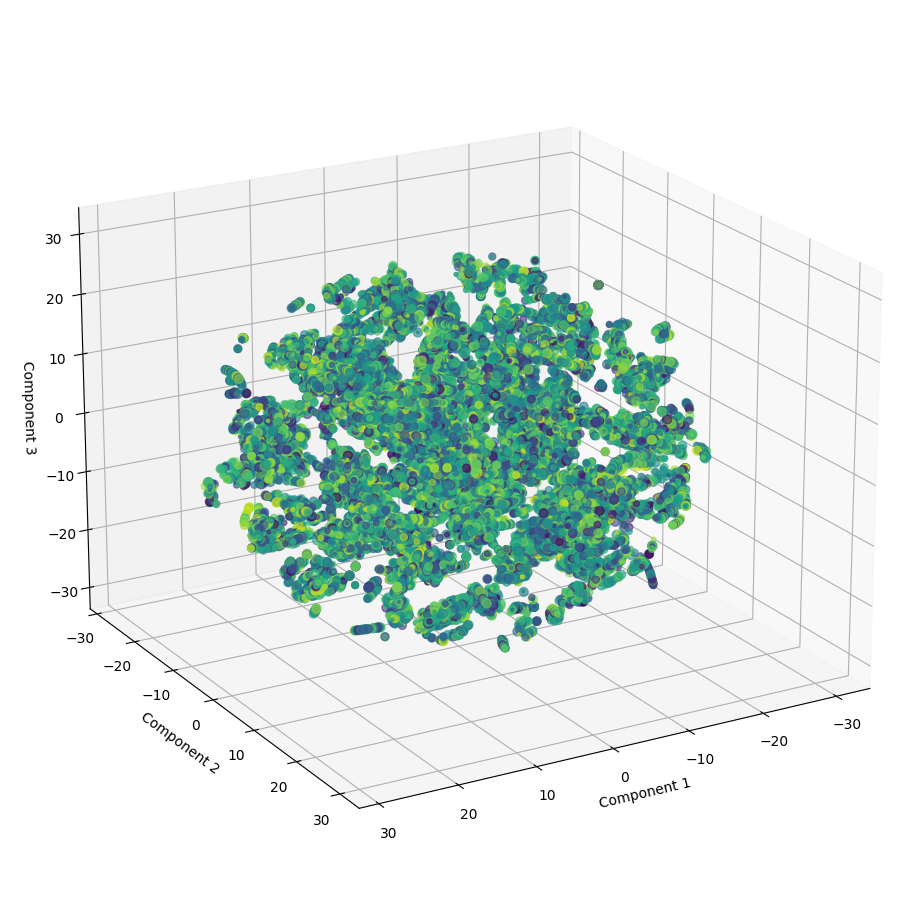

In [117]:
tsne_df3['accuracy'] = tsne_df2['target']
new_tsne_df3 = tsne_df3[tsne_df3['accuracy']>0.87]
# generate data
from sklearn.preprocessing import MinMaxScaler

x = new_tsne_df3['Component 1'].values
y = new_tsne_df3['Component 2'].values
z = new_tsne_df3['Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
scaler = MinMaxScaler(feature_range=(5,40))
new_tsne_df3['target_scaled'] = scaler.fit_transform(new_tsne_df3[['target']])

vals = scaler.fit_transform(new_tsne_df3[["accuracy"]])
sc = ax.scatter(x, y, z, s=new_tsne_df3['target_scaled'].values, c=vals, marker='o', cmap=cmap, alpha=0.6)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# save
plt.savefig("tsne_scatter_hue", bbox_inches='tight')

In [3]:
import numpy as np
batch_vals = []
for i in range(1285):
    path = f"/home/ec2-user/nas-rec-engine/gmm_training/{i}.npy"
    arr = np.load(path)
    print(arr.shape)
    batch_vals.append(arr)

(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(5, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(31, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(26, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(8, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(14, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(32, 512)
(3

In [6]:
from sklearn.mixture import GaussianMixture
import torch
import numpy as np

gm = GaussianMixture(n_components=32, random_state=109, verbose=2, warm_start=True, init_params="k-means++", tol=1e-4, max_iter=400)
gm.fit(np.concatenate(batch_vals))

Initialization 0
  Iteration 10	 time lapse 213.22525s	 ll change 0.03072
  Iteration 20	 time lapse 201.37810s	 ll change 0.01219
  Iteration 30	 time lapse 200.36738s	 ll change 0.00099
  Iteration 40	 time lapse 200.42597s	 ll change 0.00720
Initialization converged: True	 time lapse 876.70556s	 ll 2647.63334


GaussianMixture(init_params='k-means++', max_iter=400, n_components=32,
                random_state=109, tol=0.0001, verbose=2, warm_start=True)

In [120]:
gm.means_.shape

(16, 512)

In [122]:
assignment = gm.predict(torch.cat(batch_vals).cpu())

In [130]:
tsne_df5 = tsne_df.copy()
tsne_df5['target'] = assignment
tsne_df5['accuracy'] = tsne_df2['target'].copy()

In [132]:
tsne_df5.head()

Unnamed: 0  Component 1  Component 2  Component 3  target  accuracy
0           0   -18.860634     1.611424   -13.055912       0  0.885951
1           1   -18.738540     1.298855   -13.473179       0  0.903813
2           2     1.981018     1.688956     3.431181       0  0.876936
3           3    -5.799727     1.980288     9.167614       0  0.878940
4           4   -14.406397    -1.998355   -20.411694       3  0.889857

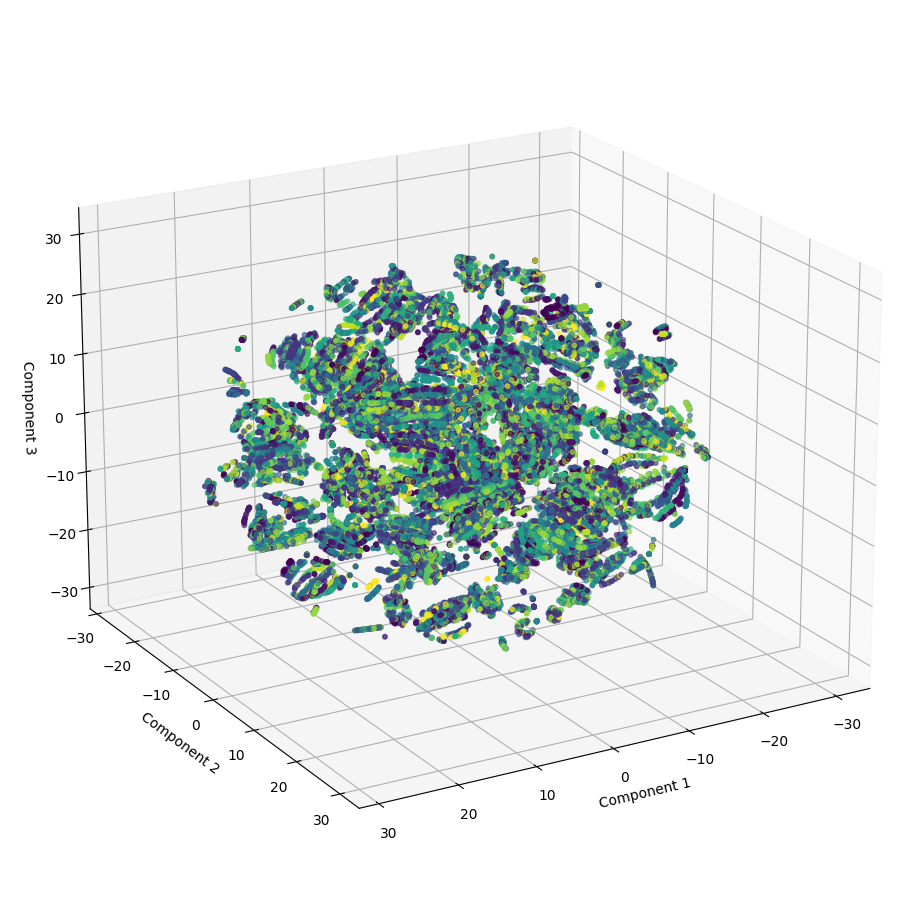

In [9]:
# generate data
import pandas as pd
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

aug = pd.read_csv("tsne_results.csv")
aug["target"] = gm.predict(np.concatenate(batch_vals))

x = aug['Component 1'].values
y = aug['Component 2'].values
z = aug['Component 3'].values

# axes instance
fig = plt.figure(figsize=(9,9))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=10, c=aug['target'], marker='o', cmap=cmap, alpha=0.6)
ax.view_init(elev=20., azim=60)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# save
plt.savefig("tsne_scatter_hue", bbox_inches='tight')

(array([6716., 4684., 5010., 2449., 4208., 4911., 1867., 2771., 4844.,
        2540.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <BarContainer object of 10 artists>)

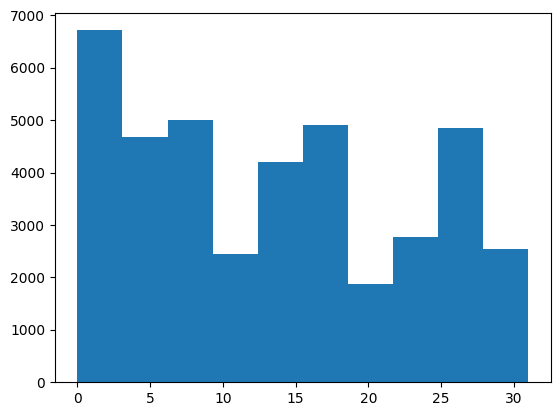

In [8]:
plt.hist(aug['target'])

In [12]:
aug['target']

0         4
1         4
2         4
3         4
4         4
         ..
39995    11
39996    11
39997    11
39998    11
39999    11
Name: target, Length: 40000, dtype: int64

In [10]:
import sklearn.mixture as mixture
# save to file
def save_gmm(gmm, name):
    gmm_name = name
    np.save(gmm_name + '_weights', gmm.weights_, allow_pickle=False)
    np.save(gmm_name + '_means', gmm.means_, allow_pickle=False)
    np.save(gmm_name + '_covariances', gmm.covariances_, allow_pickle=False)
    print("GMM Saved", name)

# reload
def load_gmm(gmm_name):
    
    means = np.load(gmm_name + '_means.npy')
    covar = np.load(gmm_name + '_covariances.npy')
    loaded_gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
    loaded_gmm.means_ = means
    loaded_gmm.covariances_ = covar
    
    return loaded_gmm



In [11]:
save_gmm(gm, "nas_assignment_model1")

GMM Saved nas_assignment_model1


In [154]:
new_gm = load_gmm("nas_assignment_model")

In [155]:
new_gm.predict(torch.cat(batch_vals).cpu())

array([0, 0, 0, ..., 0, 0, 0])

In [152]:
from model_src.gmm import GaussianMixture
torch_gm = GaussianMixture(n_components=16).to(device())

TypeError: __init__() missing 1 required positional argument: 'n_features'

In [145]:
new_gm

GaussianMixture(n_components=16)

In [151]:
torch_gm.fit(torch.cat(batch_vals))

OutOfMemoryError: CUDA out of memory. Tried to allocate 625.00 GiB (GPU 0; 14.62 GiB total capacity; 3.05 GiB already allocated; 10.25 GiB free; 3.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF